In [1]:
import numpy as np
from matplotlib import pyplot as plt
pi = np.pi
import os

In [3]:
LKsrc = '../../publicdataset/flows/LK/'
LKvids = os.listdir(LKsrc+'Wy_20')+ os.listdir(LKsrc+'Wy_50')
LKvids

['Wy_20_Oct12.npz',
 'Wy_20_Oct13.npz',
 'Wy_20_Oct14.npz',
 'Wy_20_Oct15.npz',
 'Wy_20_Oct16.npz',
 'Wy_20_Oct17.npz',
 'Wy_20_Oct19.npz',
 'Wy_50_Oct12.npz',
 'Wy_50_Oct13.npz',
 'Wy_50_Oct14.npz',
 'Wy_50_Oct15.npz',
 'Wy_50_Oct16.npz',
 'Wy_50_Oct17.npz',
 'Wy_50_Oct19.npz']

In [4]:
alphasdeg = np.linspace(40,-60,11) # elevations
alphas = np.multiply(pi/180,alphasdeg)
ncams = 2
nframes = 400
patchsz = 25
center = 20
xinds = np.arange(0,2*patchsz,2,dtype='uint8')
yinds = np.arange(1,2*patchsz,2,dtype='uint8')
timestep = 5/100
dates = [f'Oct1{i}' for i in range(2,10) if i != 8]
dates

['Oct12', 'Oct13', 'Oct14', 'Oct15', 'Oct16', 'Oct17', 'Oct19']

In [7]:
# make ground truth templates

def pitch(a):
    return np.array([[1,0,0],[0,np.cos(a),np.sin(a)],[0,-np.sin(a),np.cos(a)]])

def yaw(a):
    return np.array([[np.cos(a),0,np.sin(a)],[0,1,0],[-np.sin(a),0,np.cos(a)]])

def roll(a):
    return np.array([[np.cos(a),-np.sin(a),0],[np.sin(a),np.cos(a),0],[0,0,1]])

def makeR(theta,alpha=0,gamma=0):
    return np.matmul(np.matmul(roll(gamma),pitch(alpha)),yaw(theta))

def getflow_local(x,y,yaw=0,pitch=0,f=1.0,Xdot=0,Ydot=0,Zdot=0,Wx=0,Wy=0,Wz=0,V0=None,geometry='sphere',flipy=False,newfig=True,ret=True,plot=False):
 
    if V0 is None:
        V0 = [[Xdot,Ydot,Zdot],[Wx,Wy,Wz]]
        
    R = makeR(yaw,pitch)
    V = np.transpose(np.matmul(R,np.transpose(V0)))
    Xdot,Ydot,Zdot = V[0]
    Wx,Wy,Wz = V[1]

    if flipy:
        y = -y
        x = -x
    
    if isinstance(geometry,float):
        mu = geometry
    elif geometry == 'const':
        mu = 1
    elif geometry == 'sphere':
        mu = 1/np.sqrt(1-(x**2+y**2))
    elif geometry == 'floor':
        mu = -np.sin(pitch+np.arctan2(y,f))
        mu[mu<0] = 0    
    elif geometry == 'floorceil':
        mu = np.abs(np.sin(pitch+np.arctan2(y,f)))
    elif geometry == 'floorceilsnell':
        mu = np.abs(np.sin(pitch+np.arctan2(y,f)))
        mu[(pitch+np.arctan2(y,f))>42*pi/180] = 0
    elif geometry == 'hybrid':
        mu = 10*np.abs(np.sin(pitch+np.arctan2(y,f))) # 10 cm above/10 cm below (Z*.1m -> mu*10/m)
        mu[(pitch+np.arctan2(y,f))>42*pi/180] = 0
    elif geometry == 'smallsphere':
        mu = 10/np.sqrt(1-(x**2+y**2)) # 10 cm sphere to match hybrid geometry
    else:
        print('invalid geometry, using const')
        mu = 1.0
        
    dx = Xdot*f*mu + -Zdot*mu*x - Wx*x*y/f + Wy*(f**2+x**2)/f - Wz*y
    dy = Ydot*f*mu + -Zdot*mu*y - Wx*(f**2+y**2)/f + Wy*x*y/f + Wz*x
    flow = np.stack([dx,dy],axis=-1)
    
    if plot:
        if newfig:
            plt.figure()
        flowincolor(flow)
        plt.quiver(dx,-dy)
        plt.title(f'translation: {Xdot:.2f}, {Ydot:.2f}, {Zdot:.2f}, \nrotation: {Wx:.2f}, {Wy:.2f}, {Wz:.2f}')
    
    if ret:
        return flow

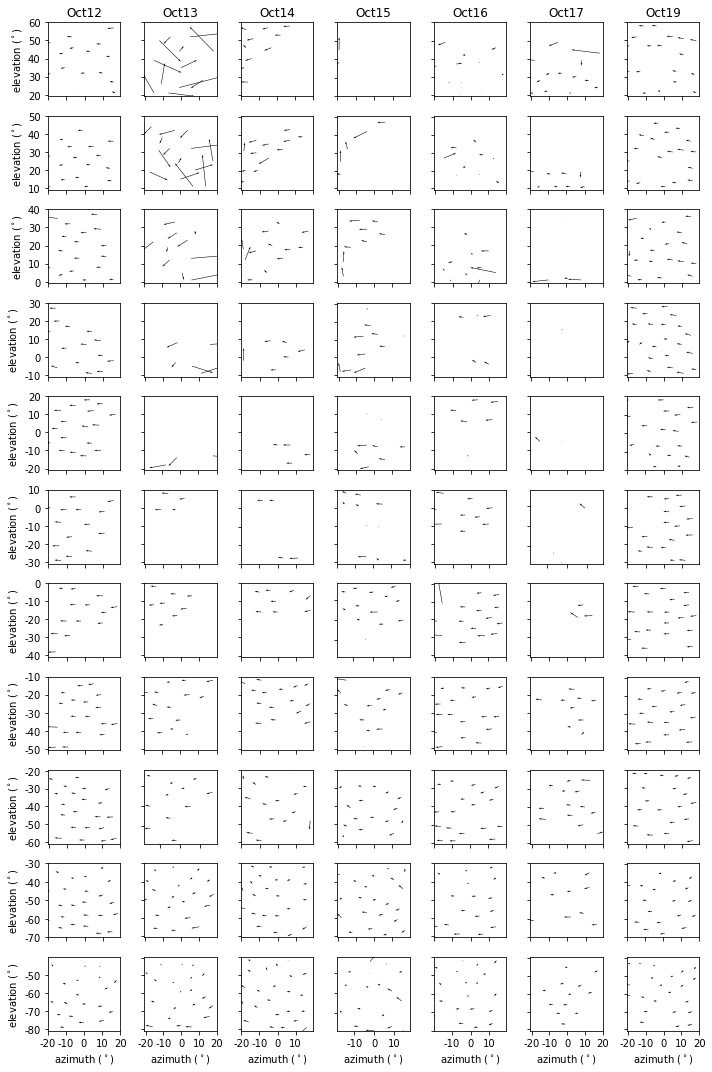

In [8]:
# illustration of flow: first sample from each site for Wy_50, 1 camera

i = 0

plt.figure(figsize=(10,15),facecolor='w')
for d in range(len(dates)):
    
    data = np.load(LKsrc+f'Wy_50/Wy_50_{dates[d]}.npz')
    rawp0s = data['p0s']
    rawp1s = data['p1s']
    rawmatchsts = data['matchsts']

    # convert to degs, take successful flows
    p0s = (rawp0s - center)
    p1s = (rawp1s - center)
    matchsts = np.repeat(rawmatchsts,2,axis=-1)
    flows = p1s-p0s
    badflows = np.copy(flows)
    flows[matchsts!=1] = np.nan
    badflows[matchsts==1] = np.nan

    qscale = 30
    for a in range(len(alphasdeg)):
        
        plt.subplot(len(alphasdeg),len(dates),len(dates)*a+d+1)
        
        xx = p0s[0,a,i,xinds]
        yy = p0s[0,a,i,yinds]
        gt = getflow_local(x=xx,y=yy,pitch=alphas[a],Wy=-50*pi/180*timestep,geometry='const') #geometry irrelevant for rotation
        plt.quiver(xx,yy,flows[0,a,i,xinds],flows[0,a,i,yinds],color='k',scale=qscale)
        plt.axis('equal')

        plt.xticks([-20,-10,0,10,20],[])
        plt.yticks([-20,-10,0,10,20],[])
        if a == 0:
            plt.title(dates[d])
        if a == len(alphasdeg)-1:
            plt.xlabel('azimuth ($^\circ$)')
            plt.xticks([-20,-10,0,10,20],[-20,-10,0,10,20])
        if d == 0:
            plt.ylabel('elevation ($^\circ$)')
            ystrs = [str(int(alphasdeg[a]+num)) for num in [-20,-10,0,10,20]]
            plt.yticks([-20,-10,0,10,20],ystrs)
plt.tight_layout()

plt.savefig(f'./final_plots/sample_flows.png', format='png',dpi=300)
plt.savefig(f'./final_plots/sample_flows.eps', format='eps',dpi=300)

In [9]:
# load data from good day
data = np.load(LKsrc+'Wy_50/Wy_50_Oct19.npz')
rawp0s = data['p0s']
rawp1s = data['p1s']
rawmatchsts = data['matchsts']

# convert to radians, take successful flows
p0s = (rawp0s - center)*pi/180
p1s = (rawp1s - center)*pi/180
matchsts = np.repeat(rawmatchsts,2,axis=-1)
flows = p1s-p0s
badflows = np.copy(flows)
flows[matchsts!=1] = np.nan
badflows[matchsts==1] = np.nan

np.shape(p0s)

(2, 11, 400, 50)

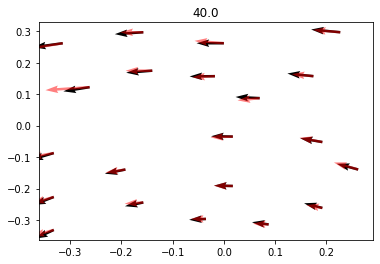

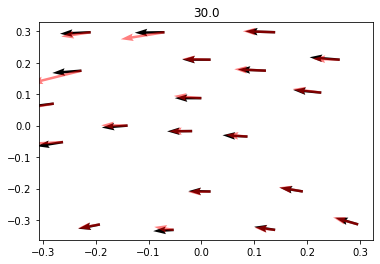

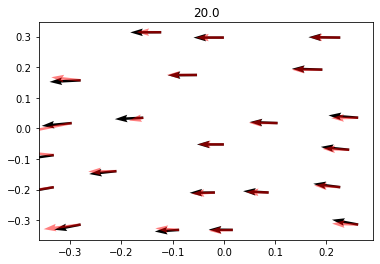

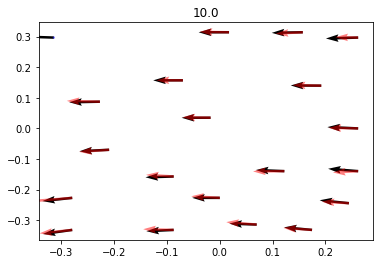

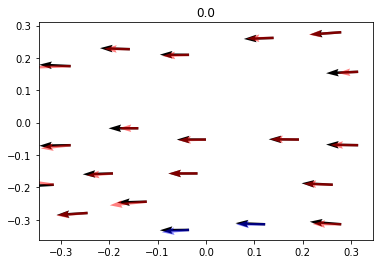

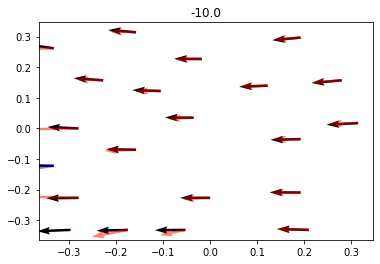

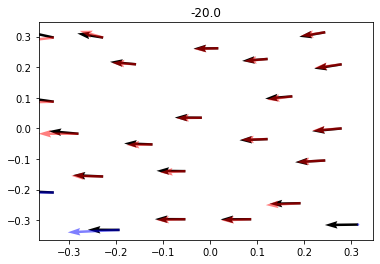

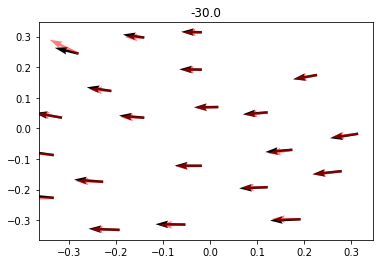

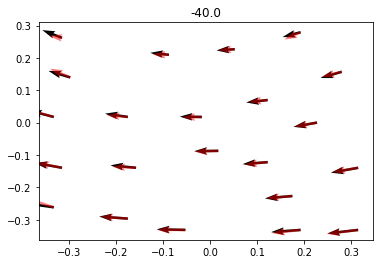

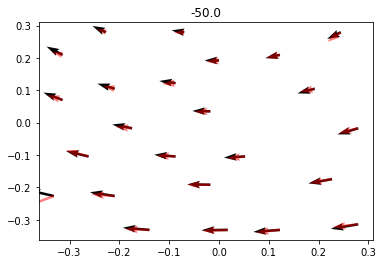

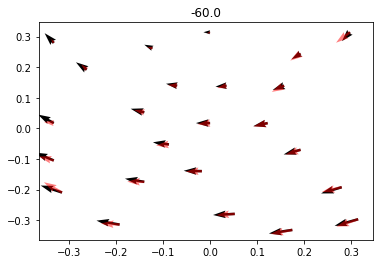

In [10]:
i = 50 # random frame to show
qscale = .5
for a in range(len(alphasdeg)):
    xx = p0s[0,a,i,xinds]
    yy = p0s[0,a,i,yinds]
    gt = getflow_local(x=xx,y=yy,pitch=alphas[a],Wy=-50*pi/180*timestep,geometry='const') #geometry irrelevant for rotation
    plt.figure()
    plt.quiver(xx,yy,gt[:,0],gt[:,1],scale=qscale)
    plt.quiver(xx,yy,flows[0,a,i,xinds],flows[0,a,i,yinds],color='r',alpha=.5,scale=qscale)
    plt.quiver(xx,yy,badflows[0,a,i,xinds],badflows[0,a,i,yinds],color='b',alpha=.5,scale=qscale)
    plt.title(alphasdeg[a])

-42.92224884033204 -42.05504945290804


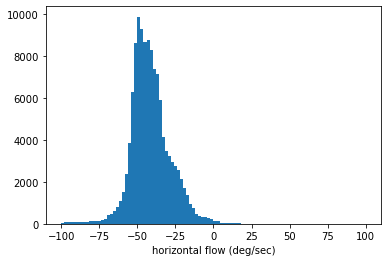

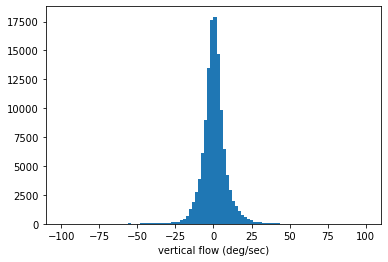

In [11]:
xflow = flows[:,:,:,xinds]*180/pi/timestep
yflow = flows[:,:,:,yinds]*180/pi/timestep

_ = plt.hist(np.ndarray.flatten(xflow),bins=100,range=[-100,100])
plt.xlabel('horizontal flow (deg/sec)')
plt.figure()
_ = plt.hist(np.ndarray.flatten(yflow),bins=100,range=[-100,100])
plt.xlabel('vertical flow (deg/sec)')
print(np.nanmedian(xflow),np.nanmean(xflow))

In [8]:
# calculate flow errors in deg/sec

speeds = ['Wy_50','Wy_20']
Wys = [-50,-20]

LKerrs = np.nan*np.ones([len(speeds),len(dates),ncams,len(alphas),nframes,2,patchsz])

for s,speed in enumerate(speeds):
    print(speed)
    for d,date in enumerate(dates):
        print('\t'+date)
        data = np.load(f'{LKsrc}{speed}/{speed}_{date}.npz',allow_pickle=True)
        rawp0s = data['p0s']
        rawp1s = data['p1s']
        rawmatchsts = data['matchsts']

        # convert pts to radians, drop failed flows
        p0s = (rawp0s - center)*pi/180
        p1s = (rawp1s - center)*pi/180
        matchsts = np.repeat(rawmatchsts,2,axis=-1)
        flows = p1s-p0s
        flows[matchsts!=1] = np.nan
        
        # put flows into deg/sec
        xflow = flows[:,:,:,xinds]*180/pi/timestep
        yflow = flows[:,:,:,yinds]*180/pi/timestep
            
        for elev,alpha in enumerate(alphas):
            for cam in range(ncams):
                for frame in range(nframes):
                    xx = p0s[cam,elev,frame,xinds]
                    yy = p0s[cam,elev,frame,yinds]
                    gt = getflow_local(x=xx,y=yy,Wy=Wys[s]*pi/180,pitch=alpha) # yaw and geometry don't affect pure Wy motion
                    gt = gt*180/pi
                
                    LKerrs[s,d,cam,elev,frame,0] = xflow[cam,elev,frame]-gt[:,0]
                    LKerrs[s,d,cam,elev,frame,1] = yflow[cam,elev,frame]-gt[:,1]
                    
LKabserrs = np.abs(LKerrs)

Wy_50
	Oct12
	Oct13
	Oct14
	Oct15
	Oct16
	Oct17
	Oct19
Wy_20
	Oct12
	Oct13
	Oct14
	Oct15
	Oct16
	Oct17
	Oct19


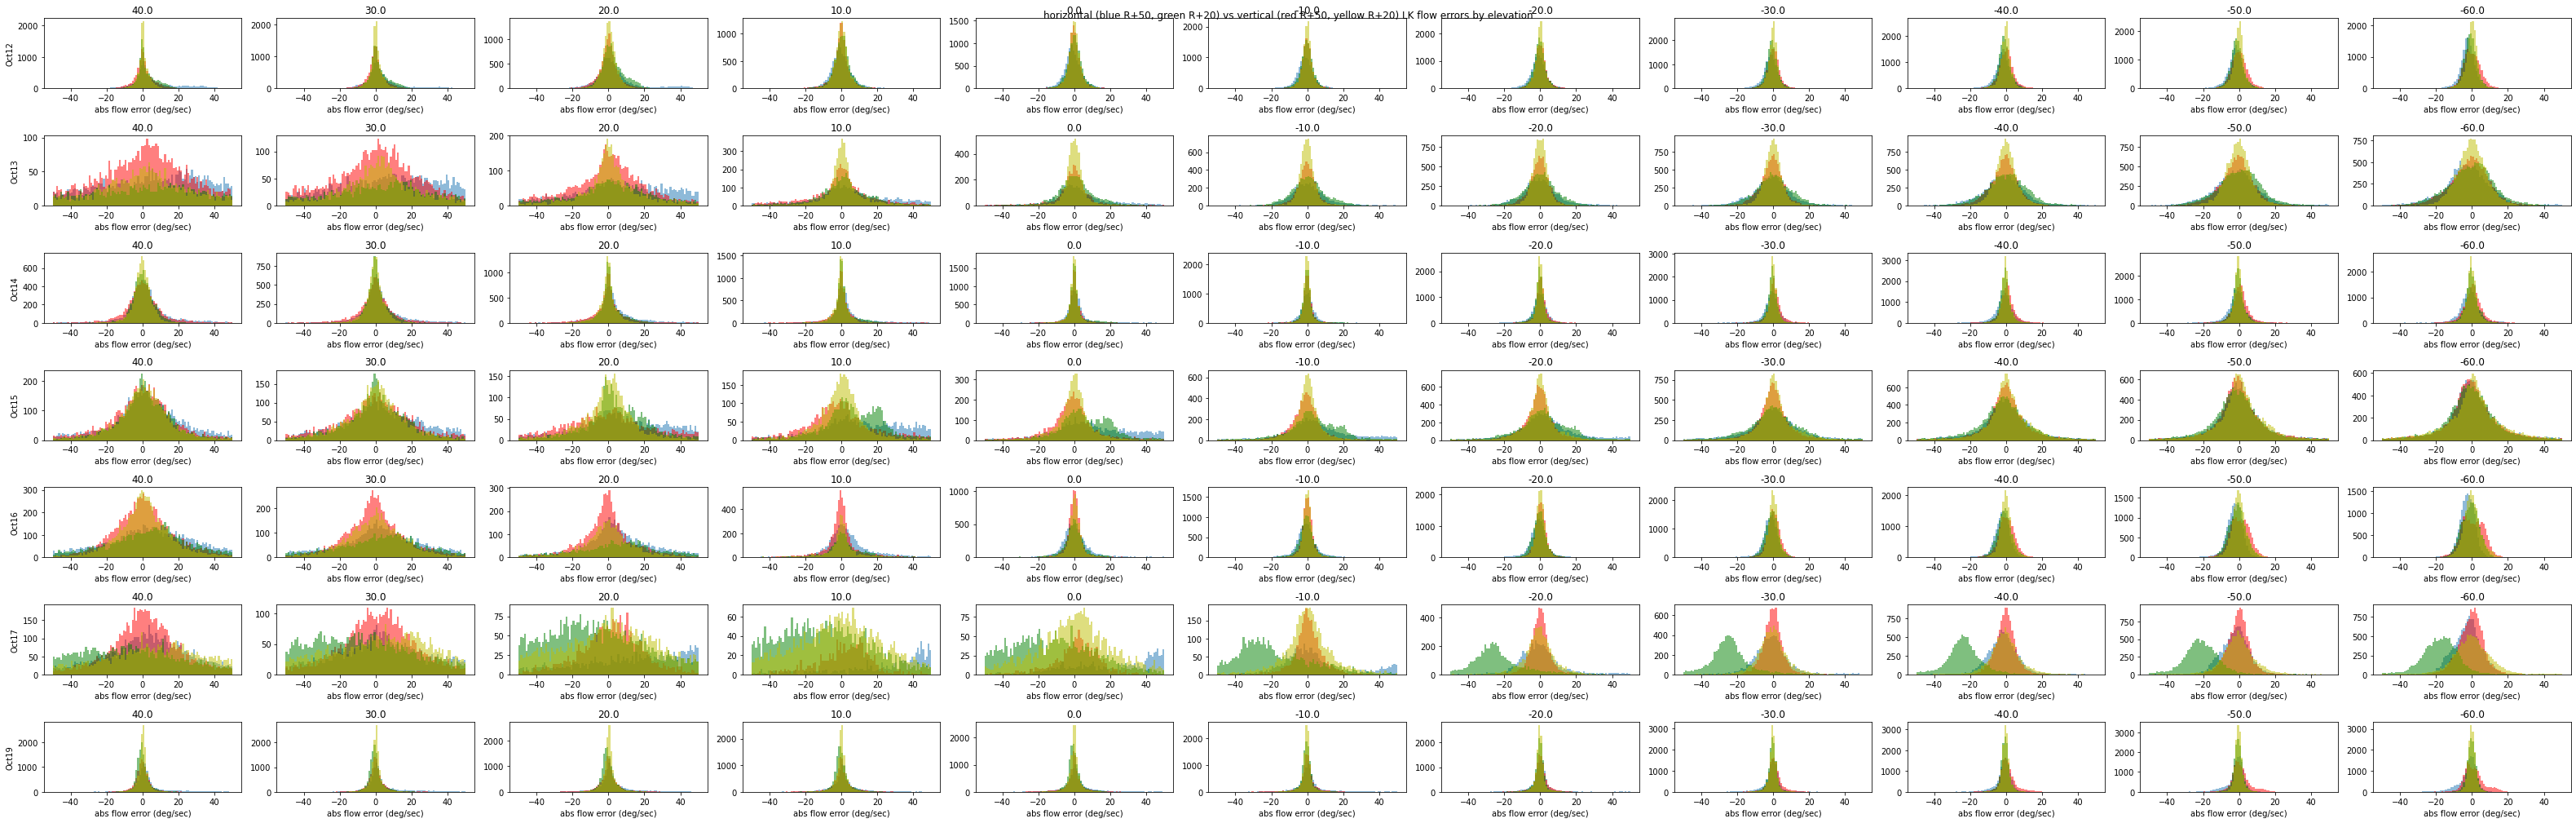

In [21]:
# show distributions of horizontal and vertical errors for both speeds
plt.figure(figsize=(len(alphas)*4,len(dates)*4),facecolor='w')  
j = 1
#binrange = [np.nanpercentile(np.ndarray.flatten(LKerrs),5),np.nanpercentile(np.ndarray.flatten(LKerrs),95)]
binrange = [-50,50]
for d in range(len(dates)):
    for a in range(len(alphas)):
        xerrs = [e for e in np.ndarray.flatten(LKerrs[0,d,:,a,:,0,:]) if not np.isnan(e) and not np.isinf(e)]
        yerrs = [e for e in np.ndarray.flatten(LKerrs[0,d,:,a,:,1,:]) if not np.isnan(e) and not np.isinf(e)]
        plt.subplot(len(dates)*len(speeds),len(alphas),j)
        j = j+1
        plt.hist(xerrs,alpha=.5,bins=100,range=binrange)
        plt.hist(yerrs,color='r',alpha=.5,bins=100,range=binrange)

        xerrs = [e for e in np.ndarray.flatten(LKerrs[1,d,:,a,:,0,:]) if not np.isnan(e) and not np.isinf(e)]
        yerrs = [e for e in np.ndarray.flatten(LKerrs[1,d,:,a,:,1,:]) if not np.isnan(e) and not np.isinf(e)]
        plt.hist(xerrs,color='g',alpha=.5,bins=100,range=binrange)
        plt.hist(yerrs,color='y',alpha=.5,bins=100,range=binrange)

        
        plt.xlabel('abs flow error (deg/sec)')
        if a == 0:
            plt.ylabel(dates[d])
        plt.title(alphasdeg[a])
plt.suptitle('horizontal (blue R+50, green R+20) vs vertical (red R+50, yellow R+20) LK flow errors by elevation')
plt.tight_layout()

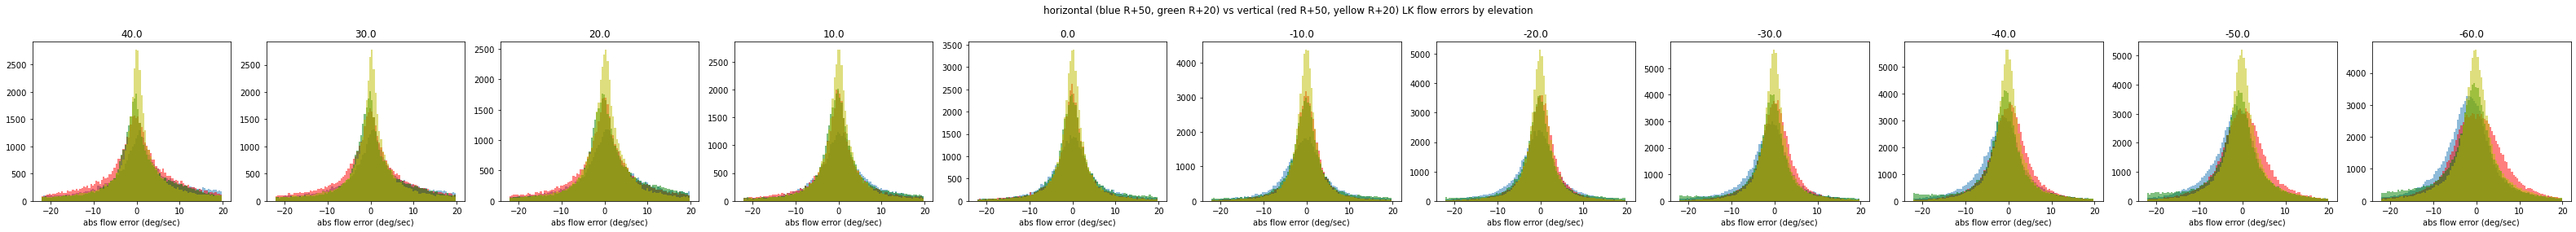

In [23]:
# show distributions of horizontal and vertical errors for both speeds
plt.figure(figsize=(len(alphas)*4,4),facecolor='w')  
j = 1
binrange = [np.nanpercentile(np.ndarray.flatten(LKerrs),5),np.nanpercentile(np.ndarray.flatten(LKerrs),95)]
#binrange = [-50,50]
for a in range(len(alphas)):
    xerrs = [e for e in np.ndarray.flatten(LKerrs[0,:,:,a,:,0,:]) if not np.isnan(e) and not np.isinf(e)]
    yerrs = [e for e in np.ndarray.flatten(LKerrs[0,:,:,a,:,1,:]) if not np.isnan(e) and not np.isinf(e)]
    plt.subplot(1,len(alphas),j)
    j = j+1
    plt.hist(xerrs,alpha=.5,bins=100,range=binrange)
    plt.hist(yerrs,color='r',alpha=.5,bins=100,range=binrange)

    xerrs = [e for e in np.ndarray.flatten(LKerrs[1,:,:,a,:,0,:]) if not np.isnan(e) and not np.isinf(e)]
    yerrs = [e for e in np.ndarray.flatten(LKerrs[1,:,:,a,:,1,:]) if not np.isnan(e) and not np.isinf(e)]
    plt.hist(xerrs,color='g',alpha=.5,bins=100,range=binrange)
    plt.hist(yerrs,color='y',alpha=.5,bins=100,range=binrange)
    plt.title(alphasdeg[a])


    plt.xlabel('abs flow error (deg/sec)')
plt.suptitle('horizontal (blue R+50, green R+20) vs vertical (red R+50, yellow R+20) LK flow errors by elevation')
plt.tight_layout()

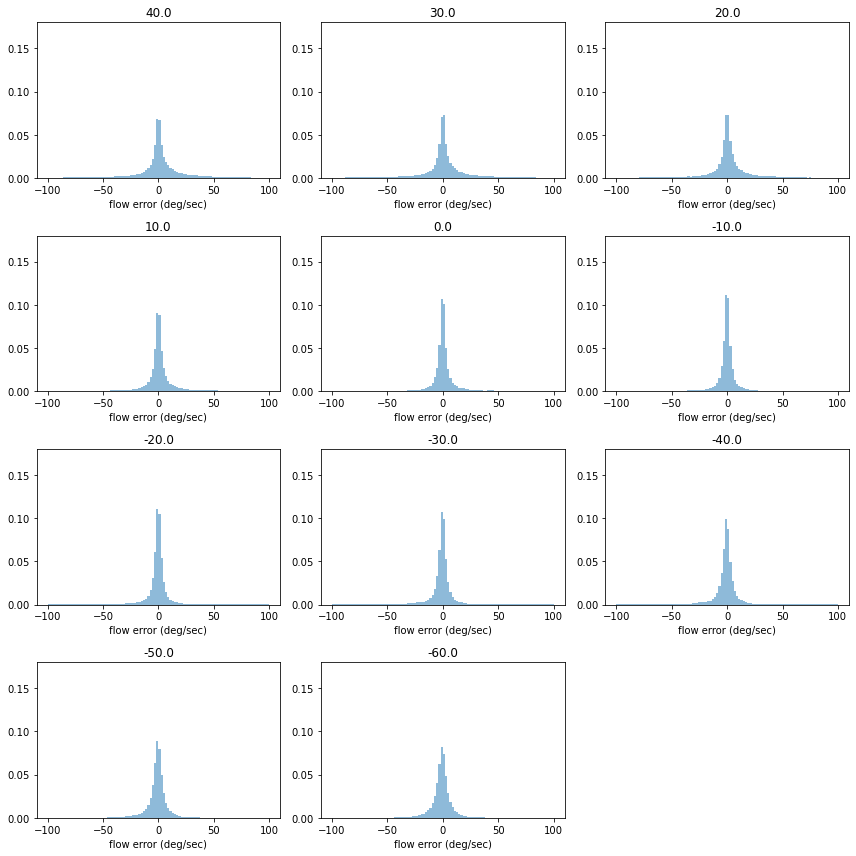

In [24]:
# histogram of errors collapsing across everything except elevation
plt.figure(figsize=(12,12),facecolor='w')  
j = 1
binrange = [-100, 100]
for a in range(len(alphas)):
    errs = [e for e in np.ndarray.flatten(LKerrs[:,:,:,a,:,:,:]) if not np.isnan(e) and not np.isinf(e)]
    plt.subplot(4,3,j)
    j = j+1
    plt.hist(errs,alpha=.5,bins=100,range=binrange,density=True)
    plt.xlabel('flow error (deg/sec)')
    plt.ylim(0,0.18)
    plt.title(alphasdeg[a])

plt.tight_layout()

In [12]:
# remove bad data
LKerrs_filtered = np.copy(LKerrs)
LKerrs_filtered[1,5,...] = np.nan  # remove site with camera malfunction
LKerrs_filtered[np.abs(LKerrs>100)] = np.nan # scene stats are warped by large errors: drop errors larger than 100 deg/sec
perelevsizes = [np.sum(~np.isnan(LKerrs_filtered[:,:,:,a,:,:,:])) for a in range(len(alphas))]
perelevmax = np.size(LKerrs_filtered)/len(alphas)
print(min(perelevsizes),max(perelevsizes),perelevmax,min(perelevsizes)/perelevmax,max(perelevsizes)/perelevmax)

167506 376012 560000.0 0.29911785714285716 0.67145


In [16]:
# calculate scene stats: sparsity, variance of errors, and kurtosis of errors

from scipy import stats

# apply data filters and calculate sparsity, variance, and kurtosis by site and overall
def errstats(filterederrs,verbose=False):
    
    sparsities_bysite = np.nan*np.ones([len(alphas),len(dates)]) #len(Wys)*ncams*nframes*patchsz potential samples
    vars_bysite = np.nan*np.ones_like(sparsities_bysite)
    kurtoses_bysite = np.nan*np.ones_like(sparsities_bysite)

    sparsities_overall = np.nan*np.ones([len(alphas)])
    vars_overall = np.nan*np.ones_like(sparsities_overall)
    kurtoses_overall = np.nan*np.ones_like(sparsities_overall)

    for a in range(len(alphas)):

        nsamps_a = 0 # track number of present samples
        Nsamps_a = 0 # track number of samples that could have been present

        for d in range(len(dates)):

            keyframes = 0
            nsamps_ad = 0
            Nsamps_ad = 0

            # count present and potential samples
            for s in range(2): # different keyframes from different speed videos
                if s == 1 and d == 5: # don't include Oct17 Wy20 in sparsity calculation
                    continue
                i = 0
                while i < nframes:
                    # skip keyframes
                    if np.all(np.isnan(filterederrs[s,d,:,a,i:i+5,:,:])):
                        i = i+5
                        keyframes = keyframes + 1
                        continue
                    nsamps_ad = nsamps_ad + np.sum(~np.isnan(filterederrs[:,d,:,a,i,:,:]))
                    Nsamps_ad = Nsamps_ad + np.size(filterederrs[:,d,:,a,i,:,:])
                    i = i+1
            
            if Nsamps_ad == 0:
                print(f'no frames on {dates[d]} at {alphasdeg[a]}')
                continue
                    
            sparsities_bysite[a,d] = (Nsamps_ad-nsamps_ad)/Nsamps_ad*100

            nsamps_a = nsamps_a + nsamps_ad
            Nsamps_a = Nsamps_a + Nsamps_ad

            vars_bysite[a,d] = np.nanvar(filterederrs[:,d,:,a,:,:,:])
            kurtoses_bysite[a,d] = stats.kurtosis(np.ndarray.flatten(filterederrs[:,d,:,a,:,:,:]),nan_policy='omit')

            if verbose:
                print('\n',alphasdeg[a],dates[d],keyframes,end=' ')
                
        sparsities_overall[a] = (Nsamps_a - nsamps_a)/Nsamps_a*100
        vars_overall[a] = np.nanvar(filterederrs[:,:,:,a,:,:,:])
        kurtoses_overall[a] = stats.kurtosis(np.ndarray.flatten(filterederrs[:,:,:,a,:,:,:]),nan_policy='omit')
    return filterederrs,sparsities_bysite,vars_bysite,kurtoses_bysite,sparsities_overall,vars_overall,kurtoses_overall
    
def ploterrstats(sparsities_bysite,variances_bysite,kurtoses_bysite,title=None,color='b',newfig=True):
    xticks = [-60,-40,-20,0,20,40]
    if newfig:
        plt.figure(figsize=(10,2.5),facecolor='w')

    plt.subplot(1,4,1)
    for d in range(len(dates)):
        plt.plot(alphasdeg,sparsities_bysite[:,d],color=color,alpha=.2)
    means = np.nanmean(sparsities_bysite,axis=1)
    stderrs = np.sqrt(np.nanvar(sparsities_bysite,axis=1))/np.sqrt(len(dates))
    plt.plot(alphasdeg,means,'-',color=color)
    plt.fill_between(alphasdeg,means-stderrs,means+stderrs,color=color,alpha=.2)
    plt.xlabel('elevation ($^\circ$)')
    plt.xlim(-60,40)
    plt.ylim(0,100)
    plt.xticks(xticks)
    plt.ylabel('sparsity (%)')

    plt.subplot(1,4,2)
    for d in range(len(dates)):
        plt.plot(alphasdeg,vars_bysite[:,d],color=color,alpha=.2)
    means = np.nanmean(vars_bysite,axis=1)
    stderrs = np.sqrt(np.nanvar(vars_bysite,axis=1))/np.sqrt(len(dates))
    plt.plot(alphasdeg,means,'-',color=color)
    plt.fill_between(alphasdeg,means-stderrs,means+stderrs,color=color,alpha=.2)
    plt.xlabel('elevation ($^\circ$)')
    plt.ylim(0,2000)
    plt.xlim(-60,40)
    plt.xticks(xticks)
    plt.ylabel('variance ($^\circ$/s)$^2$')

    plt.subplot(1,4,3)
    for d in range(len(dates)):
        plt.plot(alphasdeg,kurtoses_bysite[:,d],color=color,alpha=.2)
    means = np.nanmean(kurtoses_bysite,axis=1)
    stderrs = np.sqrt(np.nanvar(kurtoses_bysite,axis=1))/np.sqrt(len(dates))
    plt.plot(alphasdeg,means,'-',color=color)
    plt.fill_between(alphasdeg,means-stderrs,means+stderrs,color=color,alpha=.2)
    plt.xlabel('elevation ($^\circ$)')
    plt.xlim(-60,40)
    plt.xticks(xticks)
    plt.ylabel('kurtosis')
    if title is not None:
        plt.suptitle(title)
    plt.tight_layout()
    return

[61.34260585 62.51135201 63.72243813 67.01022704 64.88167314 57.20433627
 48.41859276 39.77214154 33.23757415 30.228063   27.93106975]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


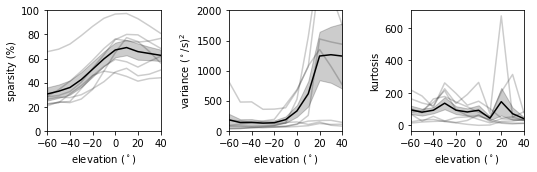

In [17]:
# show effects of different filtering
_,sparsities_bysite,vars_bysite,kurtoses_bysite,sparsities_overall,_,_ = errstats(LKerrs_filtered,verbose=False)
ploterrstats(sparsities_bysite,vars_bysite,kurtoses_bysite,color='k')
print(sparsities_overall)

plt.savefig(f'./final_plots/final_LK_noisemodel.png', format='png',dpi=300)
plt.savefig(f'./final_plots/final_LK_noisemodel.eps', format='eps',dpi=300)

In [18]:
# fit generalized Gaussians to error distributions

from scipy.optimize import minimize,least_squares
from scipy import stats
from scipy.special import gamma

# generalized Gaussian model
def prob(x,params):
    sigma,beta = params
    return beta/(2*sigma*gamma(1/beta)) * np.exp(-np.abs(x/sigma)**beta)
def loglikelihood(xs,params):
    L = 0
    for x in xs:
        L = L+np.log(prob(x,params))
    return L

# initial params for gen gauss model
params0 = [1,.5]

#binlim = 100
binlim = 50

def modelfromdata(errs,params0=params0,color='gray'):
    
    params = np.nan*np.ones([len(alphas),2])
    perfs = np.nan*np.ones(len(alphas))
    
    plt.figure(figsize=(2,18),facecolor='w')  
    #plt.figure(figsize=(4*len(alphas),4),facecolor='w')
    for a in range(len(alphas)):
        dxdylist = np.ndarray.flatten(errs[:,:,:,a,...])
        data = [d for d in dxdylist if not np.isnan(d)]
        
        ax1 = plt.subplot(len(alphasdeg),1,a+1)
        hist, bin_edges, _ = plt.hist(data,bins=5*patchsz,range=[-binlim,binlim],facecolor=color,density=True)
        plt.ylim(0,.2)
        plt.xticks([-50,0,50],[])
        plt.yticks([0,.1,.2],[0,.1,.2])
        if a == len(alphasdeg)-1:
            plt.xticks([-50,0,50],[-50,0,50])
            plt.xlabel('flow error (deg/sec)')
        plt.ylabel('probability')

        plt.tight_layout()
        
        
        def negloglikelihood(params):
            return -loglikelihood(data,params)/len(data)
    
        try:
            res = minimize(negloglikelihood,params0,method='Nelder-Mead')
            params[a] = res['x']
            perfs[a] = -negloglikelihood(res['x'])
            plt.plot(bin_edges,prob(bin_edges,res['x']),'-k')
        except Exception as e:
            print(e)
    return params,perfs


sitecolors = ['red','darkorange','gold','lime','turquoise','dodgerblue','indigo','violet']

def modelfromdata_bysite(errs,color='gray',nsamples=-1,init=None,params0=params0):
    
    params = np.nan*np.ones([len(alphas),len(dates),2])
    perfs = np.nan*np.ones([len(alphas),len(dates)])
    
    plt.figure(figsize=(4*len(alphas),4*len(dates)),facecolor='w')
    for d in range(len(dates)):
        for a in range(len(alphas)):
            dxdylist = np.ndarray.flatten(errs[:,d,:,a,...])
            data = [datum for datum in dxdylist if not np.isnan(datum)]
            if len(data) == 0:
                continue
            if nsamples>0:
                data = random.shuffle(np.copy(data))
                data = data[:nsamples]
        
            plt.subplot(len(dates),len(alphas),d*len(alphas)+len(alphas)-a)
            hist, bin_edges, _ = plt.hist(data,bins=5*patchsz,range=[-binlim,binlim],facecolor=sitecolors[d],density=True)
            plt.ylim(0,.2)
            plt.title(f'{alphasdeg[a]}')

            def negloglikelihood(params):
                return -loglikelihood(data,params)/len(data)
            if init is not None:
                params0 = init[a]
            res = minimize(negloglikelihood,params0,method='Nelder-Mead')

            params[a,d] = res['x']
            perfs[a,d] = -negloglikelihood(res['x'])
            plt.plot(bin_edges,prob(bin_edges,res['x']),'--k')
    return params,perfs

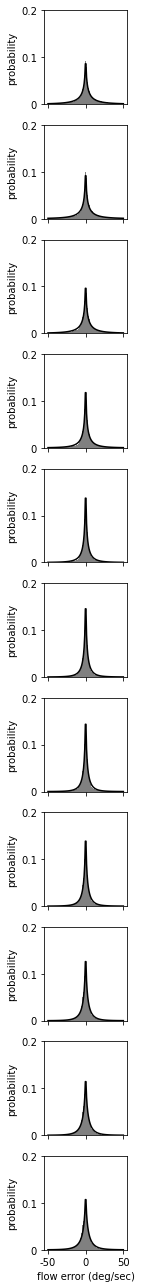

In [19]:
params,perfs = modelfromdata(LKerrs_filtered)
plt.savefig(f'./final_plots/final_LK_distributions.png', format='png',dpi=300)
plt.savefig(f'./final_plots/final_LK_distributions.eps', format='eps',dpi=300)

In [103]:
params

array([[0.945543  , 0.41324449],
       [0.75939695, 0.40043585],
       [0.84083792, 0.41700667],
       [0.71956128, 0.43254874],
       [0.76700457, 0.46822423],
       [0.97988532, 0.51886733],
       [1.18255235, 0.55071252],
       [1.35039504, 0.56855028],
       [1.69578376, 0.59252586],
       [2.18604247, 0.6292485 ],
       [2.36382315, 0.62748426]])

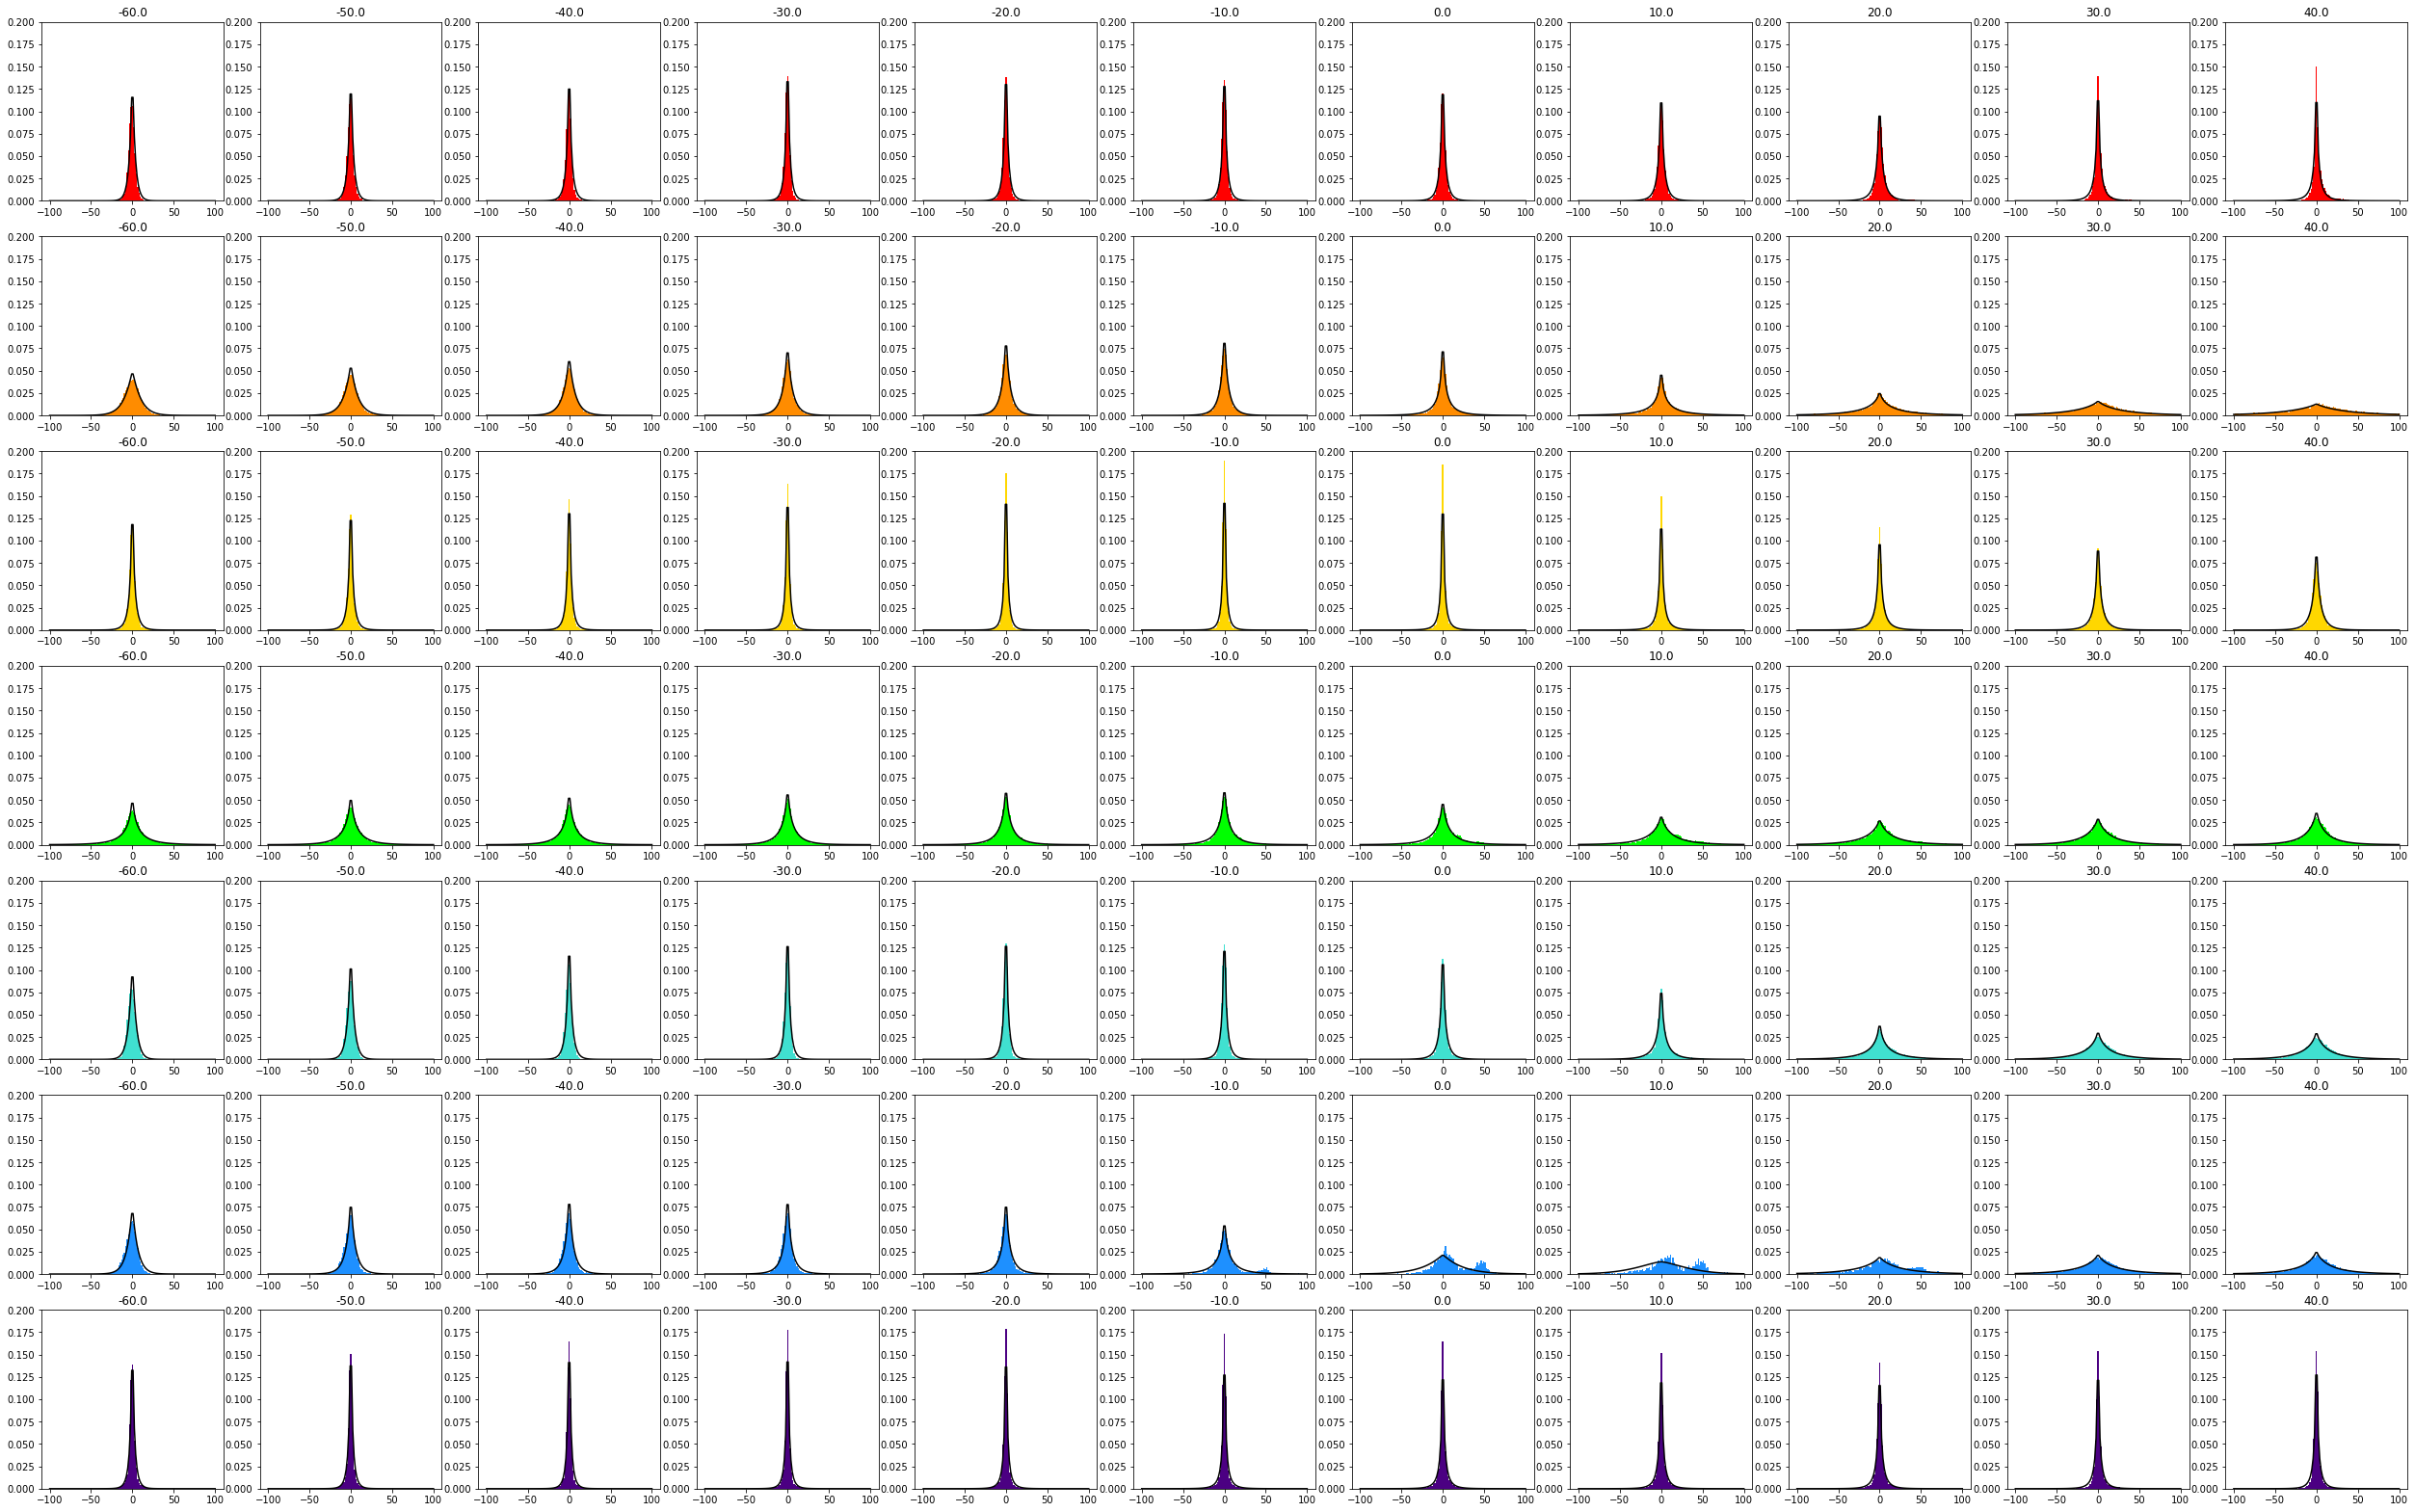

In [104]:
params_bysite,perfs_bysite = modelfromdata_bysite(LKerrs_filtered)

In [105]:
params_bysite

array([[[ 0.84962018,  0.49595309],
        [35.95401633,  0.87893707],
        [ 3.4281024 ,  0.70834902],
        [10.48750803,  0.75700379],
        [12.70096033,  0.73759995],
        [16.33596383,  0.77806147],
        [ 0.89199219,  0.54656215]],

       [[ 1.21182395,  0.55710495],
        [27.1171132 ,  0.8094882 ],
        [ 2.23045158,  0.60619001],
        [13.66820822,  0.77875376],
        [12.12637385,  0.72169446],
        [19.34462196,  0.78685179],
        [ 0.79669488,  0.51422703]],

       [[ 2.37534397,  0.65212162],
        [12.36020029,  0.63843819],
        [ 1.40554975,  0.53477467],
        [14.08819244,  0.74994585],
        [ 6.94961156,  0.60526322],
        [23.4222159 ,  0.83597246],
        [ 0.95757301,  0.52690708]],

       [[ 1.99332741,  0.66588996],
        [ 3.52890419,  0.50450229],
        [ 0.67440408,  0.47370481],
        [11.77480211,  0.73826804],
        [ 2.47837257,  0.56937442],
        [40.34308241,  1.46485321],
        [ 0.8297947 , 

In [106]:
perfs, perfs_bysite

(array([-4.17068802, -4.1131716 , -4.00807555, -3.67534118, -3.38557834,
        -3.22720777, -3.20669893, -3.23488672, -3.33402748, -3.41375969,
        -3.4997575 ]),
 array([[-3.25476187, -5.47730812, -3.56144373, -4.53123803, -4.77904789,
         -4.91715667, -2.95025049],
        [-3.19276432, -5.34520367, -3.54027806, -4.73704472, -4.78168766,
         -5.06340066, -3.05321274],
        [-3.40023197, -5.10633622, -3.48006208, -4.84646491, -4.6812369 ,
         -5.13793362, -3.14866031],
        [-3.17061364, -4.61302599, -3.20823391, -4.70133215, -3.83745172,
         -4.97392533, -3.10160022],
        [-3.0376633 , -3.95050099, -2.89627241, -4.37697625, -3.26696252,
         -4.77232789, -3.0463002 ],
        [-2.91256425, -3.54331556, -2.70743476, -4.07290786, -3.03121677,
         -4.20392656, -2.94800756],
        [-2.87768372, -3.54323583, -2.73400751, -4.06313512, -2.92760105,
         -3.71095141, -2.79818051],
        [-2.82663665, -3.6380306 , -2.79065146, -4.0733765 , 

/var/folders/vr/1mzynlbd42dfym77k97z2srm0000gn/T/ipykernel_3642/2378490315.py:20: RuntimeWarning: All-NaN axis encountered
  separations[d,cam,elev,frame,pt] = np.nanmin(dists)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


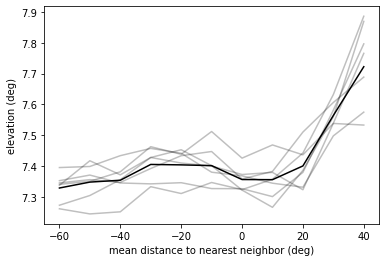

In [20]:
# example of higher-order sparsity modeling: histogram of distance to nearest neighbor
# calculate flow errors in deg/sec

separations = np.nan*np.ones([len(dates),ncams,len(alphas),nframes,patchsz])

speed = 'Wy_50'

for d,date in enumerate(dates):
    data = np.load(f'{LKsrc}{speed}/{speed}_{date}.npz',allow_pickle=True)
    p0s = data['p0s'] # keep in degrees, only using distances so no need to subtract center
    # optional: could filter p0s based on, e.g. flow performance, we include all here
    for elev,alpha in enumerate(alphas):
        for cam in range(ncams):
            for frame in range(nframes):
                xx = p0s[cam,elev,frame,xinds]
                yy = p0s[cam,elev,frame,yinds]
                # find distance to nearest neighbor
                for pt in range(patchsz):
                    dists = [np.sqrt((xx[pt]-xx[p])**2+(yy[pt]-yy[p])**2) for p in range(patchsz) if p != pt]
                    separations[d,cam,elev,frame,pt] = np.nanmin(dists)
                    
plt.figure(facecolor='w')
for d in range(len(dates)):
    mean_separations = [np.nanmean(np.ndarray.flatten(separations[d,:,elev,:,:])) for elev in range(len(alphas))] 
    plt.plot(alphasdeg,mean_separations,color='k',alpha=.25)
mean_separations = [np.nanmean(np.ndarray.flatten(separations[:,:,elev,:,:])) for elev in range(len(alphas))] 
plt.plot(alphasdeg,mean_separations,color='k')
plt.xlabel('mean distance to nearest neighbor (deg)')
plt.ylabel('elevation (deg)')

plt.savefig(f'./final_plots/final_LK_clumpiness.png', format='png',dpi=300)
plt.savefig(f'./final_plots/final_LK_clumpiness.eps', format='eps',dpi=300)